# Tweet Emotion Recognition: Natural Language Processing with TensorFlow

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## Introduction


## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 846 kB/s eta 0:00:01
     |████████████████████████████████| 243 kB 42.8 MB/s eta 0:00:01


In [46]:
#import packages
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(15, 15))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
#load dataset
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
#preview dataset
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
#define train, val, and test sets
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
#extract tweets
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
#read tweets into train set
tweets, labels = get_tweets(train)

In [8]:
#example
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

#create tokenizer object with most commonly used 10000 words
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

#fit on training sentences
tokenizer.fit_on_texts(tweets)

#numeric values of first tweet
print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

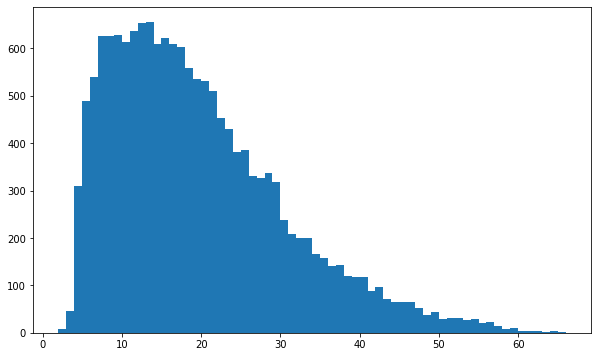

In [10]:
#length of tweets
lengths = [len(t.split(' ')) for t in tweets]

#plot
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=len(set(lengths)));

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#set maxlen=50, if too long = truncated, if too short = padded
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [12]:
#pad train tweets
padded_train_sequences = get_sequences(tokenizer, tweets)

In [13]:
#see example
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [14]:
#get classes
classes = set(labels)
print(classes)

{'love', 'anger', 'fear', 'joy', 'sadness', 'surprise'}


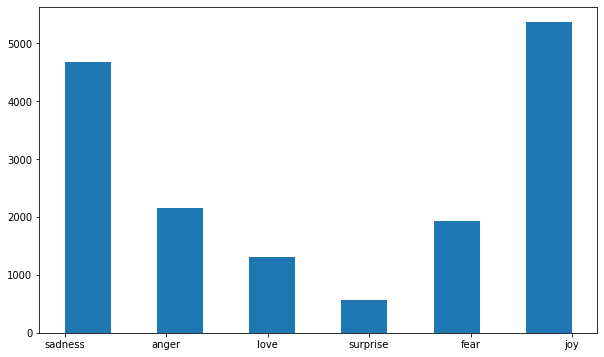

In [15]:
#plot classes
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=11)
plt.show()

In [16]:
#index all classes
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [17]:
classes_to_index

{'love': 0, 'anger': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}

In [18]:
index_to_classes

{0: 'love', 1: 'anger', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

In [19]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [20]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


## Creating the Model

1. Creating the model
2. Compiling the model

In [21]:
#model architect
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(10000, 16, input_length=50),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')])

#complile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


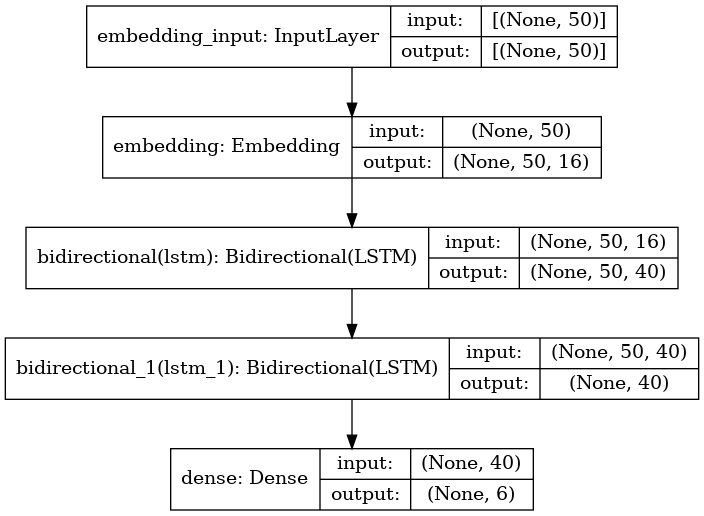

In [22]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [23]:
#save model
model.save('model.h5')

## Training the Model

1. Preparing a validation set
2. Training the model

In [24]:
#get validation set
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
#see example
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [26]:
#fit model
history = model.fit(padded_train_sequences, train_labels,
                    validation_data=(val_sequences, val_labels),
                    epochs=20,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/20
500/500 [==============================] - 24s 38ms/step - loss: 1.5420 - accuracy: 0.3745 - val_loss: 0.9656 - val_accuracy: 0.6455
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.7502 - accuracy: 0.7234 - val_loss: 0.6117 - val_accuracy: 0.7810
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.4241 - accuracy: 0.8597 - val_loss: 0.5478 - val_accuracy: 0.8260
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2716 - accuracy: 0.9125 - val_loss: 0.4217 - val_accuracy: 0.8565
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2039 - accuracy: 0.9310 - val_loss: 0.3601 - val_accuracy: 0.8875
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.1419 - accuracy: 0.9559 - val_loss: 0.4572 - val_accuracy: 0.8630
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.1177 - accuracy: 0.9620 - val_loss: 0.3575 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

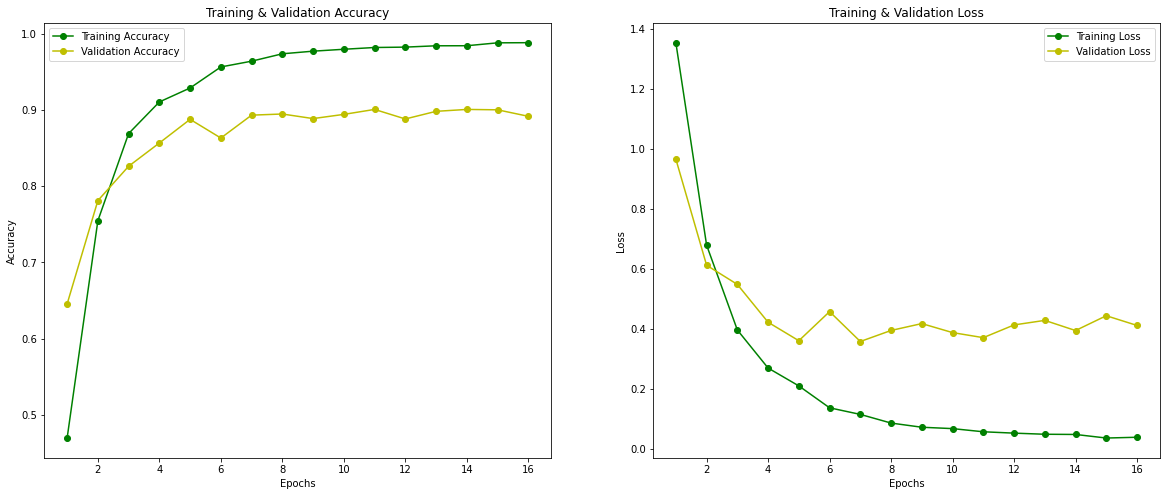

In [27]:
#plot history
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [28]:
#prepare test set
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
#evaluate
print('Train loss & accuracy:', model.evaluate(padded_train_sequences, train_labels))
print('\n')
print('Test loss & accuracy:', model.evaluate(test_sequences, test_labels))

500/500 [==============================] - 7s 12ms/step - loss: 0.0382 - accuracy: 0.9881
Train loss & accuracy: [0.038214534521102905, 0.9880625009536743]


63/63 [==============================] - 1s 11ms/step - loss: 0.4308 - accuracy: 0.8795
Test loss & accuracy: [0.43079280853271484, 0.8794999718666077]


In [30]:
#predict random tweet
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

pred = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(pred).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i cannot even begin to express in words the depth of sorrow that i feel having not posted any of my ludicrous rants over the passed days
Emotion: surprise
Predicted Emotion: surprise


In [41]:
#prediction
y_preds = model.predict_classes(test_sequences)

#check out shape
y_preds.shape, test_labels.shape

((2000,), (2000,))

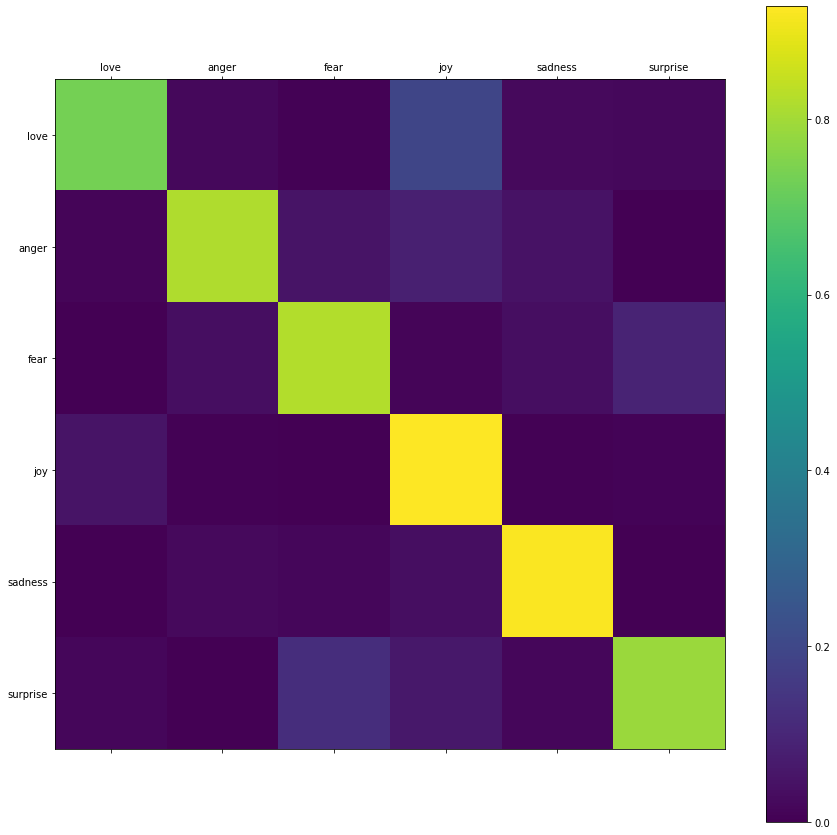

In [47]:
#plot confusion matrix
show_confusion_matrix(test_labels, y_preds, list(classes))